In [3]:
#tensorflow 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


In [4]:
# device list에 GPU있나 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 89205268849350498
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7362957312
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8234346428473185652
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [5]:
#라이브러리 설치
!pip install transformers
!pip install keras==2.6

!pip install scikit-learn

#필요한 모듈 불러오기
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, utils

# attention mask 시각화를 위한 모듈
from bertviz import model_view
utils.logging.set_verbosity_error()


from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


print("GPU available:",torch.cuda.is_available())

GPU available: True


In [6]:
def printNpRatio(df):
    neg = len(df[df['polarity'] == 0])
    pos=len(df[df['polarity'] == 1])
    print("positive: {}, negative: {}".format(pos,neg))
    print("positive {:.4f}, negative {:.4f}".format(pos/(pos+neg),neg/(pos+neg)))

In [7]:
def printLenStat(df,colName):
    lendf = pd.DataFrame()
    lendf['length'] = df[colName].apply(len)
    print(lendf.length.describe())

In [8]:
# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
url='./data/service_total.csv'
df = pd.read_csv(url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,en_ParkChaletGardenRestaurant_477778210:3,When I got there I sat up stairs where the atm...,service,0
1,en_MercedesRestaurant_478010603:4,Can get busy on Fridays for a table but once s...,service,1
2,3511,"A gentleman, maybe the manager, came to our ta...",service,0
3,2846,"Not only was the food outstanding, but the lit...",service,1
4,en_SchoonerOrLater_477965850:7,A brief conversation with the manager at the e...,service,0


In [9]:
printNpRatio(df)
print()
printLenStat(df,'text')

positive: 497, negative: 433
positive 0.5344, negative 0.4656

count    930.000000
mean      90.240860
std       49.354521
min        9.000000
25%       54.000000
50%       82.000000
75%      116.750000
max      370.000000
Name: length, dtype: float64


In [10]:
text = df.text.values
labels = df.polarity.values

In [11]:
# 전처리
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [12]:
MAX_LENGTH=150
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer,max_len_input=MAX_LENGTH):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = max_len_input,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)

  # token_id 리스트 추출
  token_id.append(encoding_dict['input_ids']) 
  # attention_mask 리스트 추출
  attention_masks.append(encoding_dict['attention_mask'])


# 리스트를 텐서로
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [13]:
# 토큰 ID와 attention mask가 잘 추출 되었는지 보자
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ they     │        2027 │                1 │
├──────────┼─────────────┼──────────────────┤
│ are      │        2024 │                1 │
├──────────┼─────────────┼──────────────────┤
│ fast     │        3435 │                1 │
├──────────┼─────────────┼──────────────────┤
│ .        │        1012 │                1 │
├──────────┼─────────────┼──────────────────┤
│ [SEP]    │         102 │                1 │
├──────────┼─────────────┼──────────────────┤
│ [PAD]    │           0 │                0 │
├──────────┼─────────────┼──────────────────┤
│ [PAD]    │           0 │                0 │
├──────────┼─────────────┼──────────────────┤
│ [PAD]    │           0 │                0 │
├──────────┼─────────────┼──────────────────┤
│ [PAD]    │           0 │        

In [14]:
VAL_RATIO= 0.2
batch_size = 8

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = VAL_RATIO,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


print("train: {}".format(len(train_idx)))
print("validation: {}".format(len(val_idx)))


train: 744
validation: 186


In [15]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])


def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N

  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)

  return b_accuracy

In [16]:
# BERT 모델 불러오기
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = True,
    output_hidden_states = False,
)


optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5, # learning rate 설정
                              eps = 1e-08
                              )

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [18]:
# GPU로 학습하도록 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 학습 횟수 설정
epochs = 15

idx=0
epo_list=[]
train_loss_list=[]
val_accuracy_list=[]

for _ in trange(epochs, desc = 'Epoch'):
    idx+=1
    epo_list.append(idx)

    # ========== Training ==========
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        
        

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    val_accuracy_temp=sum(val_accuracy)/len(val_accuracy)
    train_loss_list.append(round(tr_loss / nb_tr_steps,4))
    val_accuracy_list.append(round(val_accuracy_temp,4))

Epoch:   7%|█████                                                                       | 1/15 [00:07<01:51,  7.99s/it]


	 - Train loss: 0.1467
	 - Validation Accuracy: 0.9010


Epoch:  13%|██████████▏                                                                 | 2/15 [00:15<01:43,  7.95s/it]


	 - Train loss: 0.0838
	 - Validation Accuracy: 0.9219


Epoch:  20%|███████████████▏                                                            | 3/15 [00:23<01:34,  7.91s/it]


	 - Train loss: 0.0368
	 - Validation Accuracy: 0.9219


Epoch:  27%|████████████████████▎                                                       | 4/15 [00:31<01:24,  7.71s/it]


	 - Train loss: 0.0324
	 - Validation Accuracy: 0.9271


Epoch:  33%|█████████████████████████▎                                                  | 5/15 [00:38<01:14,  7.44s/it]


	 - Train loss: 0.0047
	 - Validation Accuracy: 0.9115


Epoch:  40%|██████████████████████████████▍                                             | 6/15 [00:45<01:05,  7.30s/it]


	 - Train loss: 0.0111
	 - Validation Accuracy: 0.9167


Epoch:  47%|███████████████████████████████████▍                                        | 7/15 [00:52<00:57,  7.22s/it]


	 - Train loss: 0.0008
	 - Validation Accuracy: 0.9062


Epoch:  53%|████████████████████████████████████████▌                                   | 8/15 [00:59<00:49,  7.14s/it]


	 - Train loss: 0.0003
	 - Validation Accuracy: 0.9115


Epoch:  60%|█████████████████████████████████████████████▌                              | 9/15 [01:06<00:42,  7.10s/it]


	 - Train loss: 0.0003
	 - Validation Accuracy: 0.9219


Epoch:  67%|██████████████████████████████████████████████████                         | 10/15 [01:13<00:35,  7.08s/it]


	 - Train loss: 0.0002
	 - Validation Accuracy: 0.9219


Epoch:  73%|██████████████████████████████████████████████████████▉                    | 11/15 [01:20<00:28,  7.08s/it]


	 - Train loss: 0.0002
	 - Validation Accuracy: 0.9167


Epoch:  80%|████████████████████████████████████████████████████████████               | 12/15 [01:27<00:21,  7.07s/it]


	 - Train loss: 0.0001
	 - Validation Accuracy: 0.9167


Epoch:  87%|█████████████████████████████████████████████████████████████████          | 13/15 [01:34<00:14,  7.08s/it]


	 - Train loss: 0.0001
	 - Validation Accuracy: 0.9167


Epoch:  93%|██████████████████████████████████████████████████████████████████████     | 14/15 [01:41<00:07,  7.06s/it]


	 - Train loss: 0.0001
	 - Validation Accuracy: 0.9167


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 15/15 [01:48<00:00,  7.24s/it]


	 - Train loss: 0.0001
	 - Validation Accuracy: 0.9167


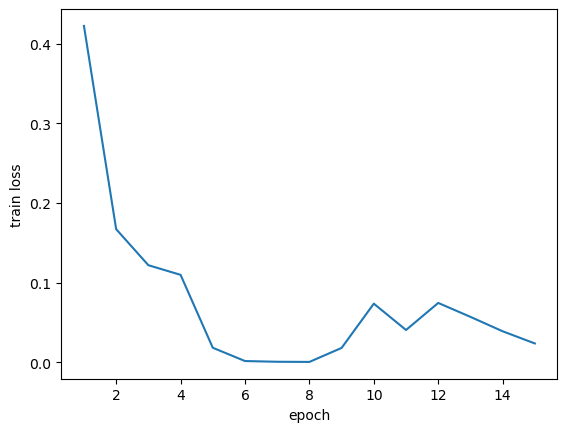

In [14]:
# train loss 그래프
plt.plot(epo_list, train_loss_list)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

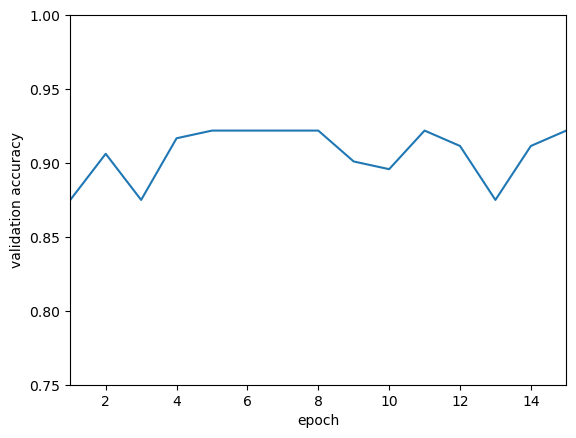

In [15]:
plt.plot(epo_list, val_accuracy_list)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.axis([1,epochs , 0.75, 1])
plt.show()

In [19]:
#새로운 리뷰를 분류해보자

def test_sentence(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction
    

    
    
new_sentence ='The food was bad, but it was cheap'
# 'It''s good, but the owner is so unkind. Some of the plates didn''t clean properly because there was something on them. But it''s cost-effective.'





print('입력 문장:', new_sentence)
print('분류:', test_sentence(new_sentence))

입력 문장: The food was bad, but it was cheap
분류: Negative


In [20]:
def testAccuracy(text,labels):
    count=0
    wrongResult=[] # [[String text,Boolean prediction ], ... ]
    rightResult=[] # [[String text,Boolean prediction ], ... ]

    for i in range(len(labels)):
        t = text[i]
        color_s='\033[31m' 
        color_e='\033[0m'
    
        prediction=test_sentence(t)
        if(prediction=="Negative"):
            result=0
        else:
            result=1
        
        if(result==labels[i]):
            count+=1     
            color_s=''
            color_e=''
            rightResult.append([t,1 if prediction=="Positive" else 0])
        else:
            wrongResult.append([t,1 if prediction=="Positive" else 0])
        print(color_s+"=============================== Input {} ===============================".format(i+1))
        print(t)
        print("model result:",prediction,"\nanswer:", labels[i],color_e)
        print("")


    print("test accuracy: {:.4f}".format(count/len(labels)))
    return rightResult,wrongResult

In [21]:
# 개별 문장의 attention 추출하는 함수
def get_attention(encoding):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        model_output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))
        
    prediction = 'Positive' if np.argmax(model_output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    attention=model_output[-1]
    last_attention=attention[-1]
    tokens=tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    
    return attention,last_attention,tokens,prediction

In [22]:
def get_val_len(ids):
    count=0
    for elem in ids:
        if(elem!=0):
            count+=1
    return count

In [23]:
def sort_by_att(attention,tokens):
    '''
        last layer의 attention tensor를 입력 받아 각 token의 attention 값을 head에 대한 평균을 낸 뒤, attention이 높은 token 순으로 idx를 반환하는 함수
    '''
    
    attention=attention[0] # shape: 12,len,len
    
    size=len(tokens)
    
    total_atts_sum=[] # 각 head에 대한 각 토큰의 attention값의 합
    for head in range(0,12):
        att_of_head=attention[head] # 한 head의 attention
        atts_sum_of_head=[0.0]*size # 해당 head 하나의 attention의 합
        for row in att_of_head:
            col=0
            for elem in row:
                value=elem.item()
                atts_sum_of_head[col]+=value # head 하나에 대한 토큰이 가지는 attention 값
                col+=1
        total_atts_sum.append(atts_sum_of_head)
    
    total_sum_value=[0.0]*size
    for elem in total_atts_sum:
        for i in range(0,size):
            total_sum_value[i]+=elem[i]
            

    total_mean=[]
    for elem in total_sum_value:
        total_mean.append(elem/12)
    
    


    idxs=sorted(range(len(total_mean)), key=lambda k: total_mean[k], reverse=True)
    return(idxs)
    

In [24]:
# attention 순서대로 텍스트 배경색 주기
color_code=[
    "\033[48;5;243m",
    "\033[48;5;245m",
    "\033[48;5;247m",
    "\033[48;5;249m",
    "\033[48;5;251m",
    "\033[48;5;253m",
    "\033[48;5;255m"
]
def emp_by_att(attIdxs,tokens):   
    valTokens=[]
    for tok in tokens:
        if(tok!='[CLS]' and tok!='[PAD]' and tok!='[SEP]'):
            valTokens.append(tok)
        
    valIdxs=[]
    for idx in attIdxs:
        if len(valIdxs)==7:
            break;
        
        if(idx>0 and idx<=len(valTokens)):
            if(valTokens[idx-1]!=',' and valTokens[idx-1]!='.'):
                valIdxs.append(idx-1)
    
    resultSent=""
    for i in range(len(valTokens)):
        if(i in valIdxs):
            outTok=color_code[valIdxs.index(i)]+valTokens[i]+"\033[0m"
        else:
            outTok=valTokens[i]
        resultSent+=outTok
        resultSent+=' '
    
    print("========================= emphasize by attention result==========================")
    print(resultSent)

In [25]:
def get_highest_att_tok(idxs,retTok,num):
    count=0
    print("highest attention: ",end="")
    for i in idxs:
        if(i<len(retTok)):
            if(retTok[i]!='[CLS]' and retTok[i]!='[SEP]' and retTok[i]!='.' and retTok[i]!=','):
                if(count<num):
                    print(retTok[i],end=" ")
                    count+=1
                

In [26]:
def empSentByAtt(sent,length,high):
    encoding = preprocessing(sent, tokenizer,length)
    
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])
    print('MAX_LEN: ',MAX_LEN_IN)
    
    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)
    idxs=sort_by_att(retLastAtt,retTok)
    emp_by_att(idxs,retTok)
    get_highest_att_tok(idxs,retTok,high)

In [27]:
#test data 세팅

# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/service_test.csv'
test_df = pd.read_csv(test_url,sep=',', header=0, encoding_errors='ignore')
test_df.head(5)


,id,text,polarity
0,33068635#1533725#2,The food is very good and the service is great.,1
1,35820984#608922#3,The staff is very sharp and they look good too.,1
2,11351819#985076#2,Waiting three hours before getting our entrees...,0
3,en_MiopostoCaffe_478542919:5,"Finally, my wife stood face to face in front o...",0
4,en_MiopostoCaffe_478542919:4,We stood there for 10 minutes while employees ...,0


In [28]:
printNpRatio(test_df)
print()
printLenStat(test_df,'text')

positive: 52, negative: 48
positive 0.5200, negative 0.4800

count    100.000
mean      86.900
std       45.612
min       15.000
25%       56.000
50%       76.000
75%      107.250
max      266.000
Name: length, dtype: float64


In [29]:
test_text = test_df.text.values
test_labels = test_df.polarity.values

rightResult,wrongResult=testAccuracy(test_text,test_labels)
    

=============================== Input 1 ===============================
The food is very good and the service is great.
model result: Positive 
answer: 1 

=============================== Input 2 ===============================
The staff is very sharp and they look good too.
model result: Positive 
answer: 1 

=============================== Input 3 ===============================
Waiting three hours before getting our entrees was a treat as well.
model result: Positive 
answer: 0 

=============================== Input 4 ===============================
Finally, my wife stood face to face in front of one of the staff and she asked, "Are you waiting for a table?"
model result: Negative 
answer: 0 

=============================== Input 5 ===============================
We stood there for 10 minutes while employees walked back and forth ignoring us.
model result: Negative 
answer: 0 

=============================== Input 6 ===============================
The service is pretty good.
mode

=============================== Input 44 ===============================
I'm glad I did as the food was very good and the staff was friendly, courteous and efficient.
model result: Positive 
answer: 1 

=============================== Input 45 ===============================
The help was extremely nice and did not rush us.
model result: Positive 
answer: 1 

=============================== Input 46 ===============================
The appetizers are ok, but the service is slow.
model result: Negative 
answer: 0 

=============================== Input 47 ===============================
I HAVE NEVER HAD A BAD MEAL(OR BAD SERVICE )@ PIGALLE.
model result: Negative 
answer: 1 

=============================== Input 48 ===============================
Tiny restaurant with very fast service.
model result: Positive 
answer: 1 

=============================== Input 49 ===============================
The bartenders and the managers are really nice and the decor is very comfy and laid-back, all t

In [31]:
#잘못 분류된 문장의 attention
for elem in wrongResult: # [[String text,Boolean prediction ], ... ]
    print('입력 문장:', elem[0]) 
    print('분류:', elem[1])

    empSentByAtt(elem[0],50,5)

    print()
    print()
    print()
    print()

입력 문장: Waiting three hours before getting our entrees was a treat as well.
분류: 1
MAX_LEN:  17
========================= emphasize by attention result==========================
waiting three hours before getting our en ##tree ##s was a treat as well . 
highest attention: well was a as treat 



입력 문장: I HAVE NEVER HAD A BAD MEAL(OR BAD SERVICE )@ PIGALLE.
분류: 0
MAX_LEN:  18
========================= emphasize by attention result==========================
i have never had a bad meal ( or bad service ) @ pig ##alle . 
highest attention: ) never bad have @ 



입력 문장: The service ranges from mediocre to offensive.
분류: 1
MAX_LEN:  12
========================= emphasize by attention result==========================
the service ranges from med ##io ##cre to offensive . 
highest attention: to from ranges offensive service 





In [32]:
#NAVER test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_service_test.csv'
n_test_df = pd.read_csv(test_url,sep=',', header=0,encoding="CP949")
n_test_df.head(5)

,id,category,text,polarity,trans_text
0,1546,service,직원이 친절하지 않습니다. \n음식이 조금 짠 편이고 가격대비는 글쎄요…,0,The staff is not friendly. The food is a littl...
1,101,service,언제나처럼 맛 그대로고 직원분들 친절하시고\n오래간만에 어린이 김밥과 쫄면 포장 잘...,1,"As always, the taste is the same and the staff..."
2,1543,service,오래전부터 단골이었는데\n가격 올리면서 고기양은 줄어들고 퀄리티는 낮아졌습니다. 직...,0,I've been a regular for a long time. As the pr...
3,88,service,음... 정말 맛있네요.\n김밥 정말 깔끔하고 맛있어요.\n야채도 듬뿍 넣어주시고요...,1,"Well, it's really good.. Kimbap is very clean ..."
4,155,service,야미야미 들리셔스 했습니다! 매장 청결 하고 매우 친절 하시고 맛도 있어요 근처 사...,1,"Yummy, yummy. I heard it! The store is clean, ..."


In [33]:
printNpRatio(n_test_df)
print()
printLenStat(n_test_df,'trans_text')

positive: 50, negative: 50
positive 0.5000, negative 0.5000

count    100.000000
mean     103.880000
std       59.416571
min       17.000000
25%       49.750000
50%       93.500000
75%      151.500000
max      217.000000
Name: length, dtype: float64


In [34]:
# naver test data에 대한 분류 및 accuracy 측정

n_test_text = n_test_df.trans_text.values
n_test_labels = n_test_df.polarity.values


NaverRightResult,NaverWrongResult=testAccuracy(n_test_text,n_test_labels)

=============================== Input 1 ===============================
The staff is not friendly. The food is a little salty and I don't know about the price…
model result: Negative 
answer: 0 

=============================== Input 2 ===============================
As always, the taste is the same and the staff are kind. It's been a long time since I packed children's gimbap and jjolmyeon well.Good luck!
model result: Positive 
answer: 1 

=============================== Input 3 ===============================
I've been a regular for a long time. As the price increased, the amount of meat decreased and the quality decreased. The employees are not very good-natured either. The service is the worst.  I won't visit again.
model result: Negative 
answer: 0 

=============================== Input 4 ===============================
Well, it's really good.. Kimbap is very clean and delicious.. Please add lots of vegetables.. Nice and quick response. Good
model result: Positive 
answer: 1 

=

=============================== Input 51 ===============================
He's kind and nice
model result: Positive 
answer: 1 

=============================== Input 52 ===============================
The dessert is good, but the cashier is unkind
model result: Positive 
answer: 0 

=============================== Input 53 ===============================
The food is delicious, but the service is not good, so I don't want to go back
model result: Negative 
answer: 0 

=============================== Input 54 ===============================
It's good. The ingredients are good and kind
model result: Positive 
answer: 1 

=============================== Input 55 ===============================
The worst employee service..
model result: Negative 
answer: 0 

=============================== Input 56 ===============================
I'm not kind, but I'm in line for cooking
model result: Negative 
answer: 0 

=============================== Input 57 ===============================
Kimbap is de

In [35]:
#잘못 분류된 문장의 attention
for elem in NaverWrongResult:
    print('입력 문장:', elem[0])
    print('분류:', elem[1])

    empSentByAtt(elem[0],70,5)

    print()
    print()
    print()
    print()

입력 문장: It's unkind. It's good
분류: 1
MAX_LEN:  12
========================= emphasize by attention result==========================
it ' s un ##kind . it ' s good 
highest attention: ' ' good s s 



입력 문장: I don't think he's always kind.. If you don't go, it's fine, but I visit you when I think of hard chicken gangjeong every once in a while.. It doesn't taste as good as before.
분류: 1
MAX_LEN:  56
========================= emphasize by attention result==========================
i don ' t think he ' s always kind . . if you don ' t go , it ' s fine , but i visit you when i think of hard chicken gang ##je ##ong every once in a while . . it doesn ' t taste as good as before . 
highest attention: ' ' ' ' ' 



입력 문장: Kimbap itself is so good  The staff members are so unkind
분류: 1
MAX_LEN:  16
========================= emphasize by attention result==========================
kim ##ba ##p itself is so good the staff members are so un ##kind 
highest attention: are members so un the 



입력 문장:

In [36]:
#잘 분류된 문장의 attention
count=0
for elem in NaverRightResult:
    count+=1
    print(count)
    print('입력 문장:', elem[0])
    print('분류:', elem[1])

    empSentByAtt(elem[0],70,5)

    print()
    print()
    print()
    print()

1
입력 문장: The staff is not friendly. The food is a little salty and I don't know about the price…
분류: 0
MAX_LEN:  24
========================= emphasize by attention result==========================
the staff is not friendly . the food is a little salty and i don ' t know about the price … 
highest attention: ' … is not the 



2
입력 문장: As always, the taste is the same and the staff are kind. It's been a long time since I packed children's gimbap and jjolmyeon well.Good luck!
분류: 1
MAX_LEN:  42
========================= emphasize by attention result==========================
as always , the taste is the same and the staff are kind . it ' s been a long time since i packed children ' s gi ##mba ##p and jj ##ol ##my ##eon well . good luck ! 
highest attention: ' ' staff i and 



3
입력 문장: I've been a regular for a long time. As the price increased, the amount of meat decreased and the quality decreased. The employees are not very good-natured either. The service is the worst.  I won't visi

========================= emphasize by attention result==========================
it ' s delicious even though it ' s packed . if you gave me a lot of na ##an and ate two meals , ra was delicious and kind . 
highest attention: ' ' kind was ra 



18
입력 문장: Sweet pumpkin soup tastes good, but it's not kind
분류: 0
MAX_LEN:  14
========================= emphasize by attention result==========================
sweet pumpkin soup tastes good , but it ' s not kind 
highest attention: ' not s kind tastes 



19
입력 문장: It tastes good.. . I don't know if it's just us, but... There was a bad smell on the table.. . I want you to pay attention to cleaning the table.
분류: 0
MAX_LEN:  46
========================= emphasize by attention result==========================
it tastes good . . . i don ' t know if it ' s just us , but . . . there was a bad smell on the table . . . i want you to pay attention to cleaning the table . 
highest attention: ' bad want you smell 



20
입력 문장: It's so nice. I want to 

========================= emphasize by attention result==========================
i went to lunch with my mother today , and both pork cut ##let and char si ##u over rice were delicious , and above all , the boss is really kind ! thank you for the delicious meal 
highest attention: and and above really is 



36
입력 문장: I went up to the second floor and ate it, but the serving members are unfriendly. Kalguksu doesn't have chewy noodles. It's really chewy. Dumplings are really good
분류: 0
MAX_LEN:  48
========================= emphasize by attention result==========================
i went up to the second floor and ate it , but the serving members are un ##fr ##ien ##dly . ka ##l ##gu ##ks ##u doesn ' t have chew ##y noodles . it ' s really chew ##y . dump ##lings are really good 
highest attention: ' ' are but members 



37
입력 문장: Honestly, the taste isn't that special It's very expensive It's not cleaned yet You only cared about the interior. It wouldn't be a waste of money if it was n

========================= emphasize by attention result==========================
it was unpleasant to put the bowl on the table when serving . the other one is 100 out of 100 
highest attention: is unpleasant when to the 



56
입력 문장: He's kind and niceSalmon and daechang and rice. Both of them were delicious!
분류: 1
MAX_LEN:  23
========================= emphasize by attention result==========================
he ' s kind and nice ##sal ##mon and da ##ech ##ang and rice . both of them were delicious ! 
highest attention: ' he and kind and 



57
입력 문장: The person serving touched the steak. I told you, but you're leaving without an apology. . It didn't taste bad.
분류: 0
MAX_LEN:  30
========================= emphasize by attention result==========================
the person serving touched the steak . i told you , but you ' re leaving without an apology . . it didn ' t taste bad . 
highest attention: ' ' touched leaving re 



58
입력 문장: First of all, the food is so good   Parking is conv

========================= emphasize by attention result==========================
it ' s a waste to give stars . . the table is not organized , and it ' s rude if you ' re a part - timer or if you have a counter . . a place i don ' t want to go again 
highest attention: ' ' ' ' and 



75
입력 문장: There are so many delicious breads. Kind and neat. There are a lot of toppings. I like it
분류: 1
MAX_LEN:  25
========================= emphasize by attention result==========================
there are so many delicious bread ##s . kind and neat . there are a lot of topping ##s . i like it 
highest attention: and neat kind many like 



76
입력 문장: All the food is good, especially. The female employee who received the order is kind and nice.
분류: 1
MAX_LEN:  22
========================= emphasize by attention result==========================
all the food is good , especially . the female employee who received the order is kind and nice . 
highest attention: female kind employee who is 



77
입력 문장:

In [37]:
#NAVER final test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_fin_service_trans.csv'
nf_df = pd.read_csv(test_url,sep=',', header=0)
nf_df.head(5)

,Unnamed: 0,id,category,text,polarity,trans_text
0,0,160,service,"평양냉면이 정말 맛있어요. 평양냉면, 온반 하나씩 시켜서 먹었는데 온반은 삼삼하고 ...",1,Pyeongyang naengmyeon is really good. I ordere...
1,1,161,service,유튜브에서 평양냉면보고 갑자기 너무 땡겨서 먹고 왔어요! \n\n친구 올 때까지 기...,1,I watched Pyeongyang naengmyeon on YouTube and...
2,2,162,service,가격은 좀 나가지만 식당 내부 깔끔하고 친절하고 무엇보다 맛있어요,1,"It's a little expensive, but the inside of the..."
3,3,163,service,평양냉면(물)과 만두한접시. 만두는 옛날 할머니가해주시던맛. 두부소으깨서 고기와들어...,1,Pyeongyang naengmyeon (water) and a plate of d...
4,4,164,service,깨끗하고 건강한맛. 주차가 불편함. 친절하지는 않음,0,a clean and healthy taste. Parking is inconven...


In [38]:
printNpRatio(nf_df)
print()
printLenStat(nf_df,'trans_text')

positive: 5, negative: 18
positive 0.2174, negative 0.7826

count     23.000000
mean     282.304348
std      234.558276
min       43.000000
25%      107.500000
50%      174.000000
75%      382.500000
max      784.000000
Name: length, dtype: float64


In [39]:
# naver final data에 대한 분류 및 accuracy 측정

nf_text = nf_df.trans_text.values
nf_labels = nf_df.polarity.values


NfRightResult,NfWrongResult=testAccuracy(nf_text,nf_labels)

=============================== Input 1 ===============================
Pyeongyang naengmyeon is really good. I ordered Pyeongyang naengmyeon and an onban, but the onban was samgyupsal and hot, so I felt so comfortable. Will the two be a good combination? I tried it, but each one was so good that I ate it well.  The staff are so kind, so I recommend it!!
model result: Positive 
answer: 1 

=============================== Input 2 ===============================
I watched Pyeongyang naengmyeon on YouTube and I suddenly craved it, so I ate it! I waited until my friend came and ordered it, but it was good that it was processed so that it could come out on time.. . And I sold mung bean pancake and dumplings individually, so I ordered just enough and ate them allThe staff were kind and the food was delicious, but the sad thing was that the distance between the tables was too close and the drunk men were noisy, so my ears hurt(Crying) (Crying) But the staff restrained me a little bit. Thank y

In [40]:
def classifyReviews(textarr):
    i=0
    
    posResult=[] # [[String text,Boolean prediction ], ... ]
    negResult=[] # [[String text,Boolean prediction ], ... ]

    neg=0
    pos=0

    for text in textarr:
        prediction=test_sentence(text)
        if(prediction=="Negative"):
            neg+=1
            negResult.append([text,0])
        else:
            pos+=1
            posResult.append([text,1])

        print("=============================== Input {} ===============================".format(i+1))
        print(text)
        print("model result:",prediction)
        print("")
        i+=1


    print("Positive ratio: {:.4f}".format(pos/len(textarr)))
    print("Negative ratio: {:.4f}".format(neg/len(textarr)))
    return posResult, negResult

In [41]:
#naver3 data 테스트

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/mongryen_service.csv'
n3_df = pd.read_csv(test_url,sep=',', header=0)
n3_df.head(5)

,id,category,text,trans_text
0,769,service,결과부터 말하자만 너무 기대가 컸던 탓인지 다시는 가고 싶지 않을 정도로 불쾌했다....,"Let me tell you the results first, but I was s..."
1,770,service,친절하시고 고기도 맛있어요,He's kind and the meat is good too
2,771,service,저녁 9인 예약하고 8인이 방문했습니다. 3/3/3 자리 셋팅으로 한명이 오지않아 ...,I made a reservation for 9 people in the eveni...
3,772,service,"서버분이 집기달라는 말에 한번에 좀 말씀해주시겠어요 하고 짜증내시는 부분에서, 이 ...","When the server asked me to pick it up, he sai..."
4,773,service,매장이 청결하고 직원분들도 친절하고 고기도 맛있습니다. 특히 냄새가 옷에 남지않아 ...,"The store is clean, the staff is kind, and the..."


In [42]:
printLenStat(n3_df,'trans_text')

count    241.000000
mean     237.257261
std      222.016141
min        8.000000
25%       80.000000
50%      158.000000
75%      294.000000
max      973.000000
Name: length, dtype: float64


In [43]:
# naver 3 data에 대한 분류
n3_text=n3_df.trans_text.values
n3_posResult,n3_negResult=classifyReviews(n3_text)

=============================== Input 1 ===============================
Let me tell you the results first, but I was so unpleasant that I didn't want to go again, maybe because I had high expectations. From the time I inquired on the wire, the lady's chilly attitude was enough to be unpleasant, but after arriving, she did not accept the order for a long time, saying that she was busy responding to the table. But I thought everything would be offset if the food was delicious, but he was also mistaken. The taste of the food was okay, and the response of the server was not good.. If you're this busy, shouldn't you at least limit the number of customers or hire more servers.. Even if you leave a review like this, you will go, but I leave a review in the hope that you will think about it at least once when someone tries to visit this place.
model result: Negative

=============================== Input 2 ===============================
He's kind and the meat is good too
model result: Positiv

=============================== Input 30 ===============================
I made a reservation because I wanted to buy delicious meat for the staff. The group seats were separated from the hall, so it was private and the service was excellent. Axe meat and pork belly are both popular, so I ate a lot^^*. Beef tartare was also delicious, so I emptied four plates. They also cut the meat sashimi. Fresh meat slaughtered on the day was the best! I think I'll come to Mongryeon again at the next get-together!
model result: Positive

=============================== Input 31 ===============================
Honestly, the food is good and the staff is kind! Make sure to eat doenjang jjigae and fried rice twice. But if it's this much, other restaurants can cook it for you... It's uncomfortable to grill and eat..crying.
model result: Positive

=============================== Input 32 ===============================
I want the staff on the second floor to be kind...You're scolding meㅜㅠ
model result: N

=============================== Input 62 ===============================
It's my third visit. I hope the part-timer doesn't get annoyed because he's busy. Anyway, it's delicious and I'm always satisfied whenever I visit!
model result: Positive

=============================== Input 63 ===============================
It's kind and the meat is light and clean
model result: Positive

=============================== Input 64 ===============================
The service is so messed up, especially the waitress... I get 20,000 won from the 2nd bottle free of charge, but the service is only ice, no glasses, and I enjoy the wine, so I carry a glass with me.. As soon as I saw the first two bottles, if I kept drinking two bottles or opening the bottle, if I was too bothered by eating, I would have won two bottles on my own, but if I just dipped it in the catcher, I would have paid on my own... If you want to order more, your mind disappears. I want an independent space for more than 6 people, so 

=============================== Input 92 ===============================
It's kind and tastes good.
model result: Positive

=============================== Input 93 ===============================
It was the best quality and most delicious pork I've ever had. All my family members are satisfied. The staff are good, too
model result: Positive

=============================== Input 94 ===============================
I was worried because there were many bad reviews about the service. I made a reservation for my parents' wedding anniversary, but first of all, I really liked it! They assigned me a good seat and the meat was really good. I ate 3 servings of thick ribs + axe meat, but I wanted to eat more, so I added 5 servings of pork belly! I could enjoy various lineups and the stew and cold noodles were great. When I made a reservation for my parents' 30th wedding anniversary, they gave me raw beef for free... ♥? Thank you so much. I'm going to revisit invincible tickets!!! However, the s

=============================== Input 124 ===============================
I was with my family, and the meat is in great condition. So of course it tastes good^^* My family said it was delicious, so I was very happy. The meat is delicious and the staff are so kind that I'm 100% willing to revisit.
model result: Positive

=============================== Input 125 ===============================
He's kind and the food plating comes out pretty. But the fire is so strong that it burns. I'm not sure about the taste compared to the price
model result: Positive

=============================== Input 126 ===============================
I really enjoyed the ax meat ^^ I think it's starting to be burnt, so the scent and flavor are added!! All the staff members are kind, too! Good, good
model result: Positive

=============================== Input 127 ===============================
I just eat it, but I really don't show it... 1. It doesn't taste good. I can't afford the price at all..     I ate 

=============================== Input 153 ===============================
The ax meat is so good^^. The atmosphere is good and the staff is kind and nice~♡. I'm willing to revisit^^
model result: Positive

=============================== Input 154 ===============================
Ax meat! It's good. I went to lunch and ordered axe meat less than 1:30 p.m., but the person serving said that I should go out at 3 p.m. because the meat order is only until 2 p.m. and it's break time from 3 p.m. if I don't go out at 3 p.m., I don't want to eat it. It was unpleasant. The staff ate from 2 o'clock... It was "Left Anxiety If you're going to do this, you'll have to break time from 2pm. I remember that the service was very good when I went there during dinner time, but I'm not sure if I'll revisit it because it's such a shame during lunch time.
model result: Negative

=============================== Input 155 ===============================
You have to make a reservation a few days in advance to eat

=============================== Input 185 ===============================
I went there once and it was delicious, but I was so busy because it was a holiday. There was a lot of smoke and children, so I ate it with my nose, but it didn't taste bad. It's a place that I often go to when I have meetings because it's neat.
model result: Positive

=============================== Input 186 ===============================
I really enjoyed the meal. It was nice and kindHaha
model result: Positive

=============================== Input 187 ===============================
It was good for the meeting and the meat was good. The free beer was also delicious. However, the service was disappointing. Did you have to put oil in the stove when all the tables were eating. Sitting at the table right next to me, I hurriedly left because of the smell. I didn't say a word of understanding.
model result: Negative

=============================== Input 188 ===============================
I was satisfied with th

=============================== Input 219 ===============================
The service and cleanliness for the price is just so-so. The meat tastes good, but it's hard to control the heat because you have to grill it yourself and you're busy grilling it. I need to cut onions or side dishes with green onion pickles to eat, but it's a shame that there's no such serve.
model result: Negative

=============================== Input 220 ===============================
The composition and taste of the meat were good, but... Meat and other menus (including alcoholic beverages) are served too late.. I had to say it a couple of times before they brought it to me, so I brought it myself and ate it... You only say that meat takes a long time because it's the weekend... I think it would be better to increase the number of employees overall in terms of service.. It was nice that the lady serving was kind.
model result: Negative

=============================== Input 221 ==============================

In [44]:
def classifyAndGetAtt(sent,length,high):
    prediction=test_sentence(sent)
    print("입력 문장: ",sent)
    print("분류: ",prediction)
    
    empSentByAtt(sent,length,high)
    print()
    print()
    print()
    

In [46]:
sent1 = "Food was very very delicious, but staff was not kind, and little expensive."
sent2 = "Terrible service, but food was delicious, and it was cost-effective."
sent3 = "It's little expensive, but tastes so good. One problem is that manager was rude."
sent4 = "It was cheap, and waiter was kind too. But the food tastes so bad."
classifyAndGetAtt(sent1,30,5)
classifyAndGetAtt(sent2,30,5)
classifyAndGetAtt(sent3,30,5)
classifyAndGetAtt(sent4,30,5)

입력 문장:  Food was very very delicious, but staff was not kind, and little expensive.
분류:  Negative
MAX_LEN:  18
========================= emphasize by attention result==========================
food was very very delicious , but staff was not kind , and little expensive . 
highest attention: not was was and staff 


입력 문장:  Terrible service, but food was delicious, and it was cost-effective.
분류:  Negative
MAX_LEN:  17
========================= emphasize by attention result==========================
terrible service , but food was delicious , and it was cost - effective . 
highest attention: and effective was terrible it 


입력 문장:  It's little expensive, but tastes so good. One problem is that manager was rude.
분류:  Negative
MAX_LEN:  21
========================= emphasize by attention result==========================
it ' s little expensive , but tastes so good . one problem is that manager was rude . 
highest attention: ' rude that was is 


입력 문장:  It was cheap, and waiter was kind to

In [47]:
sentence="Food was so delicious, and it was not that expensive. But one of the staff looked angry."
classifyAndGetAtt(sentence,30,5)

입력 문장:  Food was so delicious, and it was not that expensive. But one of the staff looked angry.
분류:  Negative
MAX_LEN:  22
========================= emphasize by attention result==========================
food was so delicious , and it was not that expensive . but one of the staff looked angry . 
highest attention: angry looked the one so 


